In [2]:
import numpy as np
import struct

In [3]:
MC_runs = 200


samples_all = []
for i in range(200):
    file_path = "./storage/mc_run_%d_data.dat" %i
    sample_size = 8
    try:
        with open(file_path, 'rb') as f:
            # Read the binary data
            binary_data = f.read()
    except:
        print("File %s not found!"%file_path)
        continue

    num_samples = len(binary_data) // sample_size
    samples = []
    for i in range(num_samples):
        # Extract real and imaginary parts from the binary data
        real_part, imag_part = struct.unpack('ff', binary_data[i * sample_size: (i + 1) * sample_size])
        # Create a complex number and append it to the list of samples
        samples.append(complex(real_part, imag_part))

    samples = np.array(samples)
    samples_all.append(samples)

print(samples_all[0].shape)

File ./storage/mc_run_69_data.dat not found!
File ./storage/mc_run_70_data.dat not found!
File ./storage/mc_run_71_data.dat not found!
File ./storage/mc_run_74_data.dat not found!
File ./storage/mc_run_75_data.dat not found!
File ./storage/mc_run_77_data.dat not found!
File ./storage/mc_run_78_data.dat not found!
File ./storage/mc_run_79_data.dat not found!
File ./storage/mc_run_80_data.dat not found!
File ./storage/mc_run_82_data.dat not found!
File ./storage/mc_run_83_data.dat not found!
File ./storage/mc_run_86_data.dat not found!
File ./storage/mc_run_87_data.dat not found!
File ./storage/mc_run_88_data.dat not found!
File ./storage/mc_run_89_data.dat not found!
File ./storage/mc_run_94_data.dat not found!
File ./storage/mc_run_95_data.dat not found!
File ./storage/mc_run_96_data.dat not found!
File ./storage/mc_run_97_data.dat not found!
File ./storage/mc_run_98_data.dat not found!
File ./storage/mc_run_99_data.dat not found!
File ./storage/mc_run_100_data.dat not found!
File ./st

In [4]:
N = 257
M_list = [31, 73, 109, 97, 173, 211, 139]

zfc_seq_list = [np.array([np.exp(-1j * np.pi * M * n * (n + 1) / N) for n in range(N)]) for M in M_list]

174


174it [00:00, 311.92it/s]


Tvar 0 2881.9827586206898 128.9364843440349
plot Tvar 0 nan nan
Tvar 1 2883.5402298850577 0.24838155634826262
2883.0
plot Tvar 1 2883.5402298850577 0.24838155634826262
Tvar 2 2875.6666666666665 1260.1417624521073
plot Tvar 2 nan nan
Tvar 3 2857.6666666666665 36927.23371647508
plot Tvar 3 nan nan
Tvar 4 2877.0 2929.0459770114944
plot Tvar 4 nan nan
Tvar 5 2876.9367816091954 3058.0707160787424
plot Tvar 5 nan nan


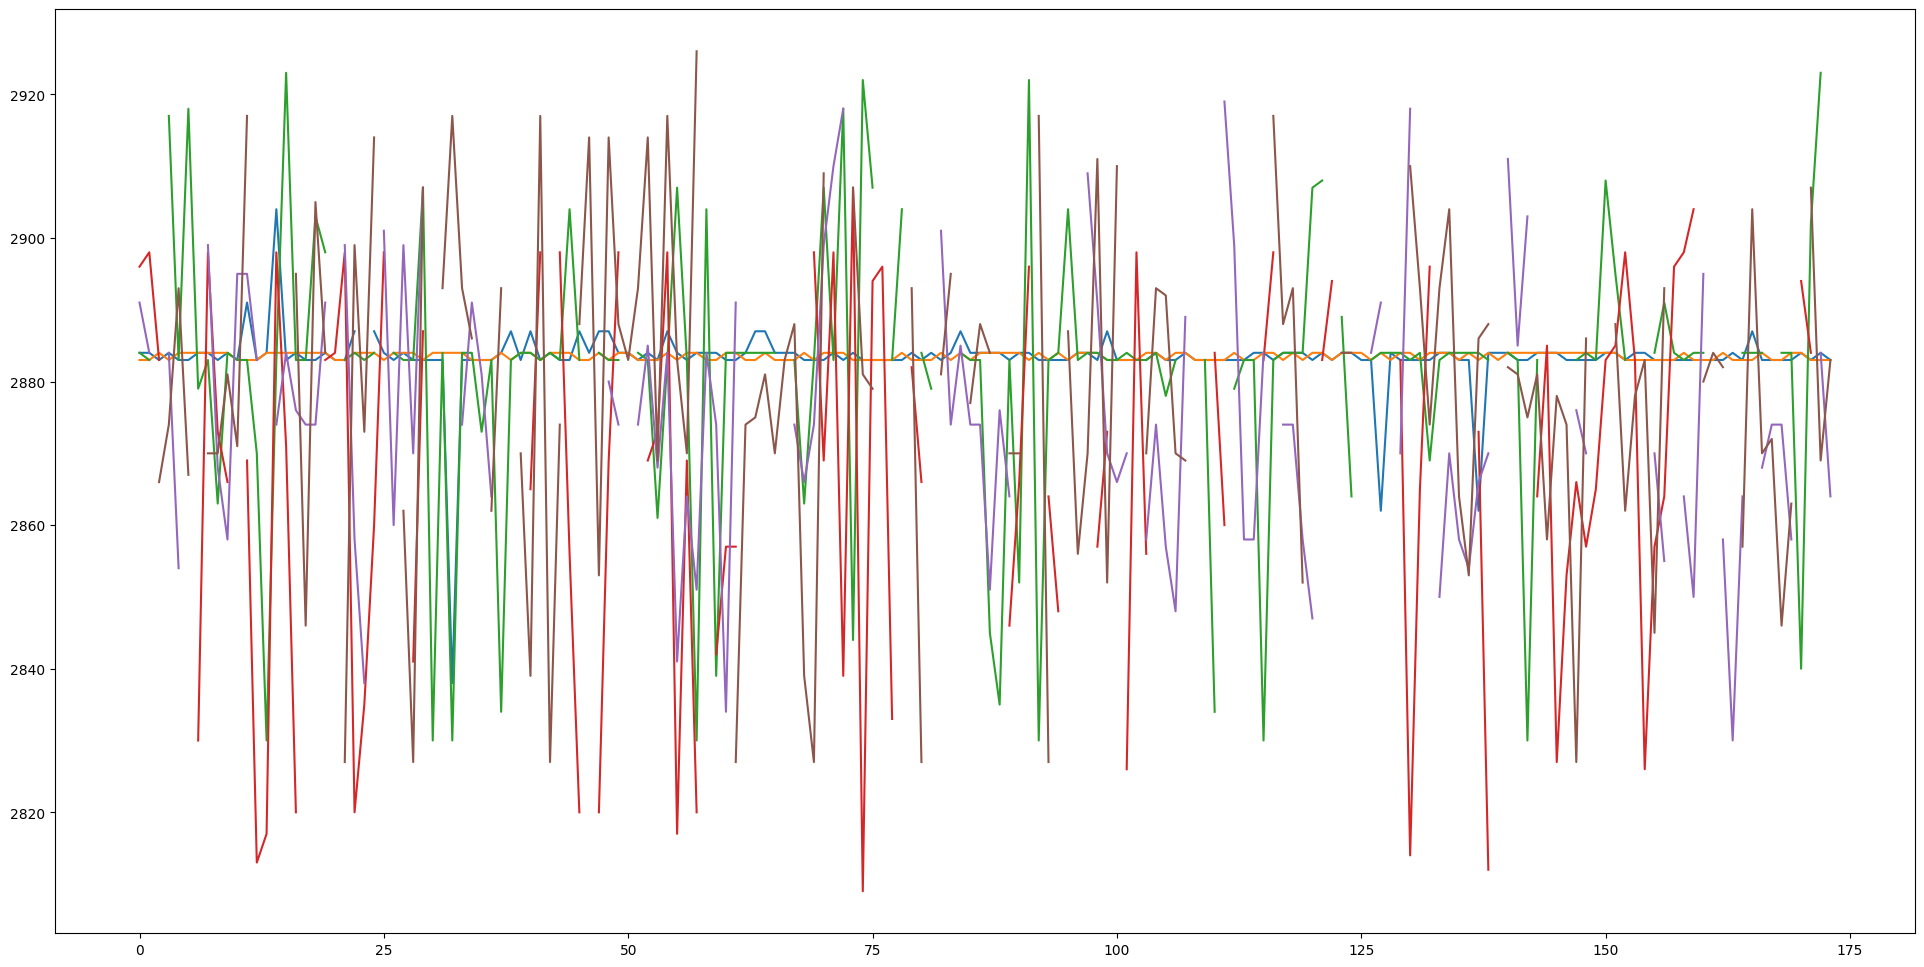

In [8]:
from tqdm import tqdm
from matplotlib import pyplot as plt

print(len(samples_all))

fig, ax = plt.subplots(figsize=[24, 12])
timing_arr = np.zeros((len(samples_all), len(M_list)), dtype=int)
vals_arr = np.zeros((len(samples_all), len(M_list)), dtype=float)
for n, samples in tqdm(enumerate(samples_all)):
    corr_zfc_list = np.array([np.correlate(samples, zfc_seq, mode='full') / N for zfc_seq in zfc_seq_list])
    for i in range(len(M_list)):
        timing_arr[n, i] = np.argmax(np.abs(corr_zfc_list[i])).item()
        vals_arr[n, i] = np.max(np.abs(corr_zfc_list[i])).item()

for i in range(len(M_list) - 1):
    timing = timing_arr[:, i]
    tmean, tvar = np.mean(timing), np.var(timing)
    print("Tvar %d"%i, tmean, tvar)
    plot_timing = np.where(np.abs(timing - tmean) < 50, timing, np.nan)
    if np.abs(np.min(timing) - tmean) < 50:
        print(plot_timing[i])
    tmean, tvar = np.mean(plot_timing), np.var(plot_timing)
    print("plot Tvar %d"%i, tmean, tvar)
    ax.plot(np.arange(len(samples_all)), plot_timing)

# for i in range(len(M_list)):
#     print("%d -- %.5e" %(np.argmax(np.abs(corr_zfc_list[i])).item(), np.max(np.abs(corr_zfc_list[i])).item()))

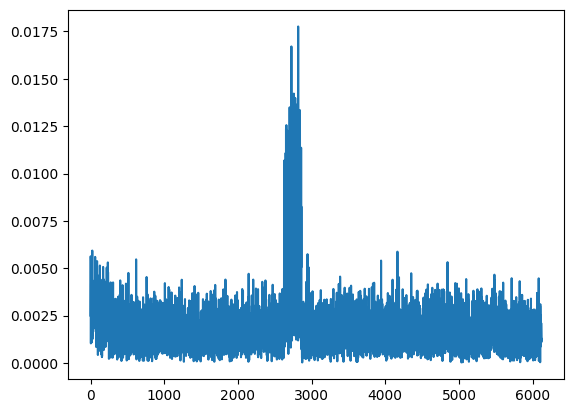

In [8]:
from matplotlib import pyplot as plt
plt.plot(np.abs(samples))

In [9]:
N = 257
M_list = [31, 73, 109, 97, 173, 211, 139]

zfc_seq_list = [np.array([np.exp(-1j * np.pi * M * n * (n + 1) / N) for n in range(N)]) for M in M_list]


In [10]:

corr_zfc_list = [np.correlate(samples, zfc_seq, mode='full') / N for zfc_seq in zfc_seq_list]

for i in range(len(M_list)):
    print("%d -- %.5e" %(np.argmax(np.abs(corr_zfc_list[i])).item(), np.max(np.abs(corr_zfc_list[i])).item()))


2883 -- 1.21398e-03
2883 -- 2.93142e-03
2883 -- 4.16138e-03
2833 -- 8.40227e-04
2885 -- 9.28803e-04
2852 -- 7.78409e-04
2884 -- 1.61695e-03


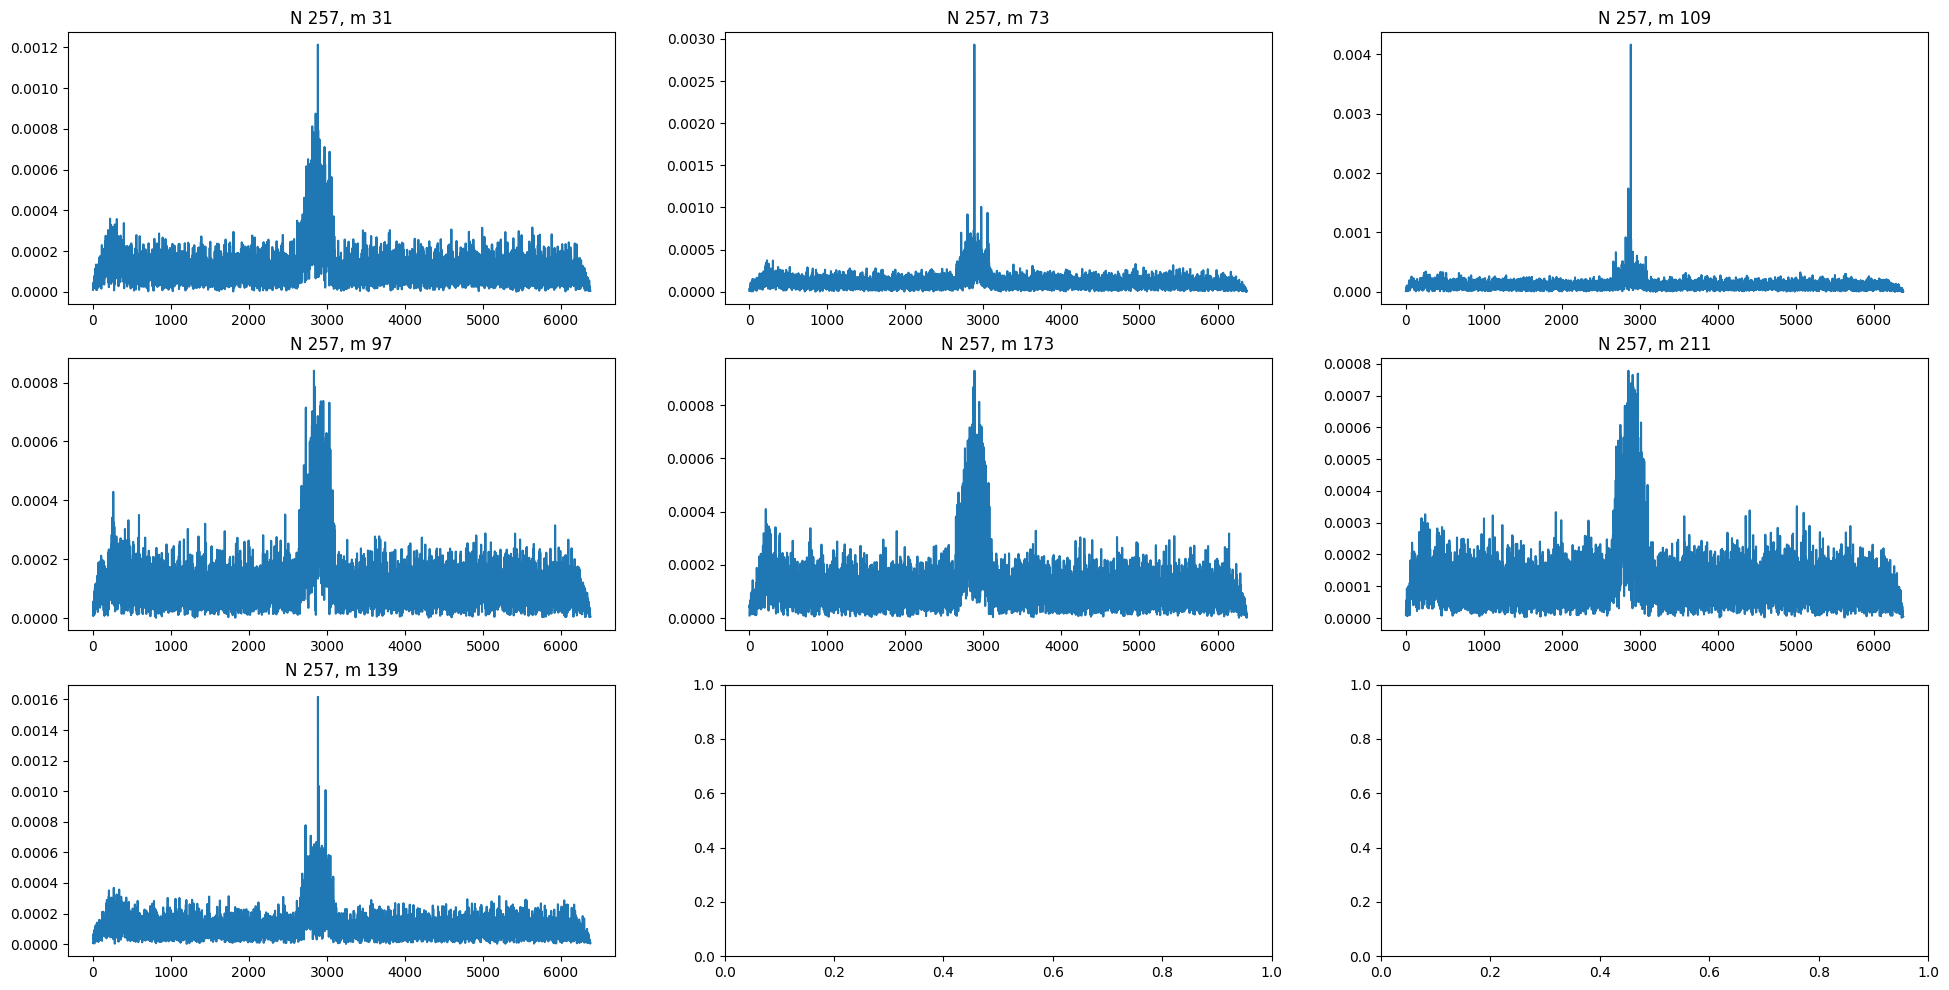

In [11]:
plot_data_list = [np.abs(corr_zfc) for corr_zfc in corr_zfc_list]

fig, ax = plt.subplots(3, 3, figsize=[24,12])
axs = ax.flatten()
for i in range(len(M_list)):
    axs[i].plot(plot_data_list[i])
    axs[i].set_title("N %d, m %d" %(N, M_list[i]))

# print(np.diff(np.argwhere(plot_data > 60.0).squeeze()))
# print(plot_data[np.argwhere(plot_data > 60.0).squeeze()])


In [ ]:
# floating window - to find the threshold
window_len = N
relevant_signal = np.abs(samples[pmax-5*N : pmax + 5*N])
ma_signal = np.zeros((relevant_signal.size - N + 1), dtype=float)
for i in range(ma_signal.size):
    for j in range(N):
        ma_signal[i] += relevant_signal[i + j]
    ma_signal[i] /= N
plt.plot(ma_signal)
print(np.max(ma_signal))
pp = np.argmax(ma_signal).squeeze()
print(np.mean(ma_signal))
print(np.mean(np.delete(ma_signal, np.arange(pp - N//2 - 1, pp + N//2 + 1))))
# plt.yscale("log")